## Minor Project
### Finger Print Detection

Loading dataset from kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download ruizgara/socofing

100% 837M/838M [00:05<00:00, 180MB/s]
100% 838M/838M [00:05<00:00, 154MB/s]


In [ ]:
! unzip socofing

Streaming output truncated to the last 5000 lines.
  inflating: socofing/SOCOFing/Real/191__F_Left_index_finger.BMP  
  inflating: socofing/SOCOFing/Real/191__F_Left_little_finger.BMP  
  inflating: socofing/SOCOFing/Real/191__F_Left_middle_finger.BMP  
  inflating: socofing/SOCOFing/Real/191__F_Left_ring_finger.BMP  
  inflating: socofing/SOCOFing/Real/191__F_Left_thumb_finger.BMP  
  inflating: socofing/SOCOFing/Real/191__F_Right_index_finger.BMP  
  inflating: socofing/SOCOFing/Real/191__F_Right_little_finger.BMP  
  inflating: socofing/SOCOFing/Real/191__F_Right_middle_finger.BMP  
  inflating: socofing/SOCOFing/Real/191__F_Right_ring_finger.BMP  
  inflating: socofing/SOCOFing/Real/191__F_Right_thumb_finger.BMP  
  inflating: socofing/SOCOFing/Real/192__M_Left_index_finger.BMP  
  inflating: socofing/SOCOFing/Real/192__M_Left_little_finger.BMP  
  inflating: socofing/SOCOFing/Real/192__M_Left_middle_finger.BMP  
  inflating: socofing/SOCOFing/Real/192__M_Left_ring_finger.BMP  
  i

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2

Pre-processing

In [ ]:
def extract_label(img_path,train = True):
  filename, _ = os.path.splitext(os.path.basename(img_path))

  subject_id, etc = filename.split('__')
  
  if train:
      gender, lr, finger, _, _ = etc.split('_')
  else:
      gender, lr, finger, _ = etc.split('_')
  
  if gender == 'M':
      gender = 0 
  else:
      gender=1
  lr = 0 if lr == 'Left' else 1

  return np.array([gender], dtype=np.uint16)


In [ ]:

img_size = 96

def loading_data(path,train):
    print("loading data from: ",path)
    data = []
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            img_resize = cv2.resize(img_array, (img_size, img_size))
            label = extract_label(os.path.join(path, img),train)
            data.append([label[0], img_resize ])
        except Exception as e:
            pass
    #data
    return data

Loading images path

In [ ]:

Real_path = "../content/socofing/SOCOFing/Real"
Easy_path = "../content/socofing/SOCOFing/Altered/Altered-Easy"
Medium_path = "../content/socofing/SOCOFing/Altered/Altered-Medium"
Hard_path = "../content/socofing/SOCOFing/Altered/Altered-Hard"

Real_data = loading_data(Real_path, train = True)
Easy_data = loading_data(Easy_path, train = True)
Medium_data = loading_data(Medium_path, train = True)
Hard_data = loading_data(Hard_path, train = True)
test = loading_data(Real_path, train = False)

train = np.concatenate([Easy_data, Medium_data, Hard_data], axis=0)

loading data from:  ../content/socofing/SOCOFing/Real
loading data from:  ../content/socofing/SOCOFing/Altered/Altered-Easy
loading data from:  ../content/socofing/SOCOFing/Altered/Altered-Medium
loading data from:  ../content/socofing/SOCOFing/Altered/Altered-Hard
loading data from:  ../content/socofing/SOCOFing/Real


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
#del Easy_data, Medium_data, Hard_data, Real_data

Normalizing

In [ ]:
import random
random.shuffle(train)
#random.shuffle(test)

In [ ]:
img, labels = [], []
for label, feature in train:
    labels.append(label)
    img.append(feature)
train_data = np.array(img).reshape(-1, img_size, img_size, 1)
train_data = train_data / 255.0

In [ ]:
from keras.utils.np_utils import to_categorical
train_labels = to_categorical(labels, num_classes = 2)

In [ ]:
img, labels = [], []
for label, feature in test:
    labels.append(label)
    img.append(feature)
test_data = np.array(img).reshape(-1, img_size, img_size, 1)
test_data = test_data / 255.0

In [ ]:
from keras.utils.np_utils import to_categorical
test_labels = to_categorical(labels, num_classes = 2)

In [ ]:
#del train, data,test

## Model

In [ ]:
print(train_labels.shape)

(49270, 2)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout,Activation, Flatten, Conv2D, MaxPool2D
from keras.utils.np_utils import to_categorical 
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
model = Sequential()

model.add(Conv2D(filters = 20, kernel_size = (3,3),padding = 'Same',activation ='relu',input_shape = (96,96,1)))
model.add(Conv2D(filters = 40, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(Conv2D(filters = 60, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(Conv2D(filters = 80, kernel_size = (3,3),padding = 'Same',activation ='relu'))

model.add(MaxPool2D(pool_size=(2,2)))


model.add(Flatten())
model.add(Dense(100, activation = "relu"))
model.add(Dense(10, activation = "relu"))

model.add(Dense(2,activation='softmax'))


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 20)        200       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 40)        7240      
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 60)        21660     
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 80)        43280     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 80)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 184320)            0         
                                                        

In [ ]:
epochs = 20
batch_size = 70
model.compile(optimizer = "adam" , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(train_data,train_labels, batch_size = batch_size, epochs = epochs, verbose = 1)

Epoch 1/3
704/704 [==============================] - 190s 251ms/step - loss: 0.3244 - accuracy: 0.8679
Epoch 2/3
704/704 [==============================] - 174s 247ms/step - loss: 0.0457 - accuracy: 0.9848
Epoch 3/3
704/704 [==============================] - 174s 247ms/step - loss: 0.0184 - accuracy: 0.9936


In [ ]:
model.evaluate(test_data, test_labels)

188/188 [==============================] - 8s 39ms/step - loss: 0.0214 - accuracy: 0.9912


[0.02137395553290844, 0.9911666512489319]

Testing

In [ ]:
# def load_image(img_path):

#     img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
#     img_resize = cv2.resize(img_array, (img_size, img_size))
   
#     train_data = np.array(img_resize).reshape(-1, img_size, img_size, 1)
#     train_data = train_data / 255.0
                               

#     return train_data

In [ ]:
# def prediction_gender(img_path):
#     new_image = load_image(img_path)
#     pred = model.predict(new_image)
#     labels = np.array(pred)
#     if(labels[0][0]>labels[0][1]):
#         print("Male")
#         s = "Male"
#     else:
#         print("Female")
#         s = "Female"
#     # p=model.predict_clasess(pred)
#     # print(p)
#     # print(labels)
#     # print(labels[0][0])
#     # print(pred)
#     return s

In [ ]:
# prediction_gender("/content/6__M_Left_middle_finger (1).BMP")

Male


'Male'

In [ ]:
# test_labels[55]

array([1., 0.], dtype=float32)

In [ ]:
# history.history.keys()

In [ ]:
# model.save_weights("model_gender.h5")

Graph Analysis

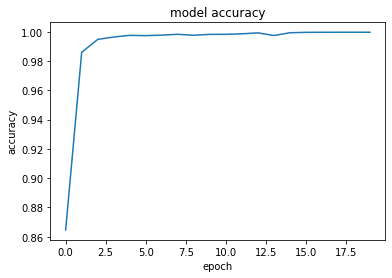

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

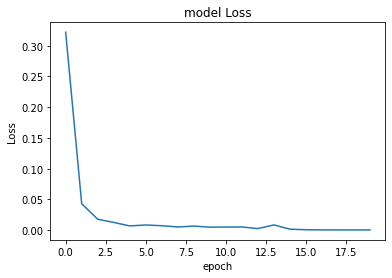

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.title('model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.show()